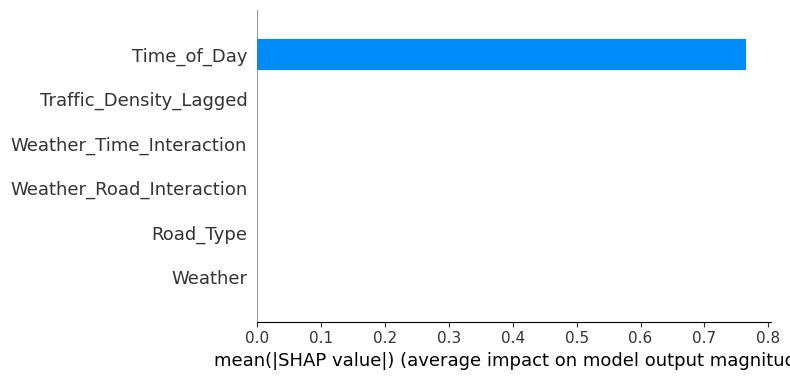

<Figure size 640x480 with 0 Axes>

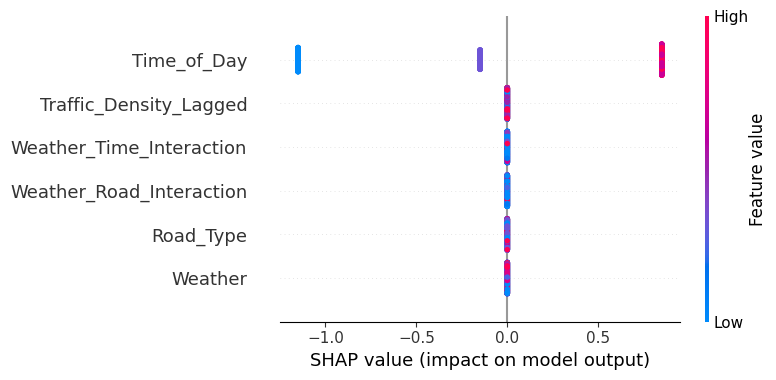

<Figure size 640x480 with 0 Axes>

Results saved successfully.


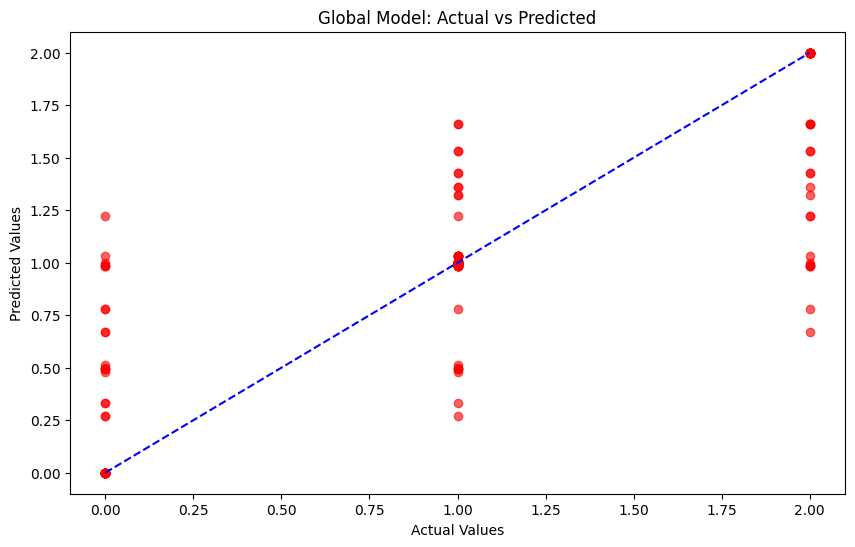

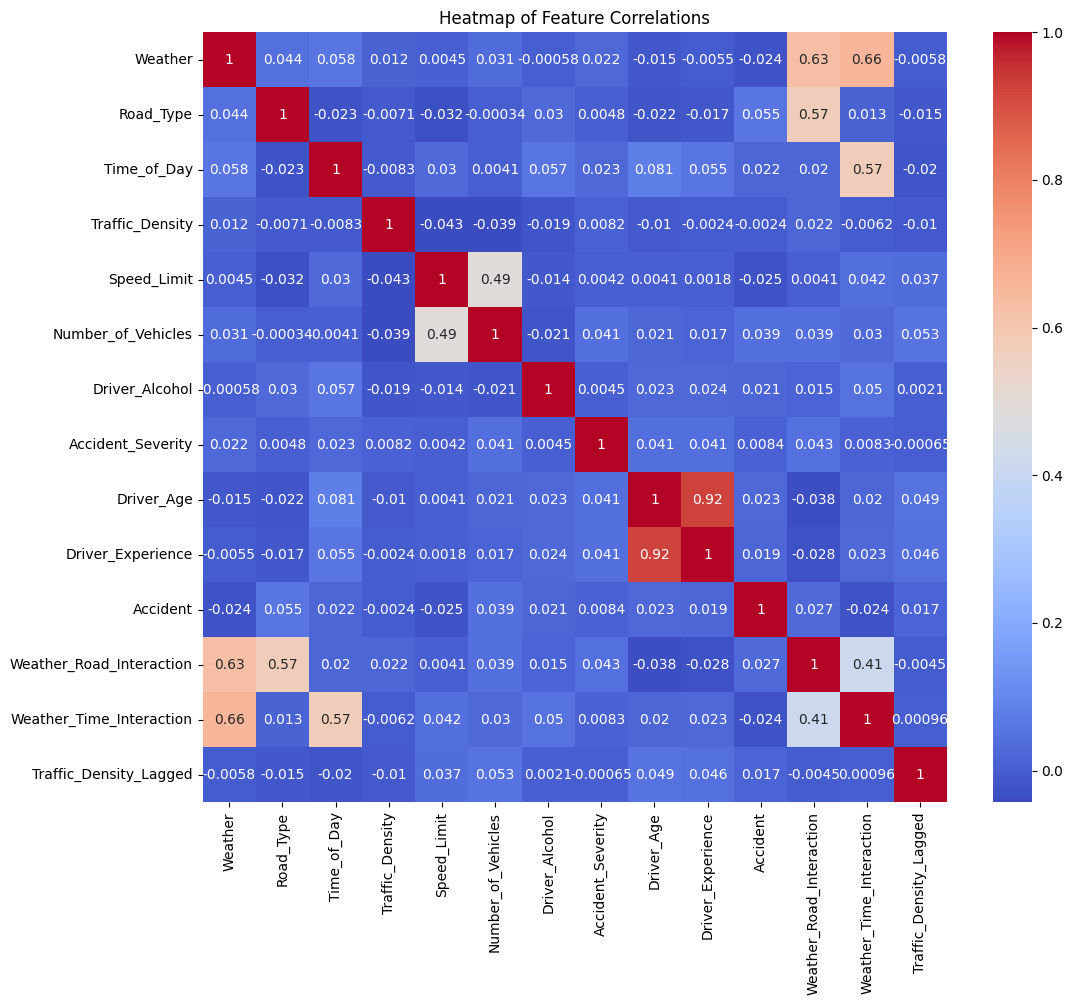

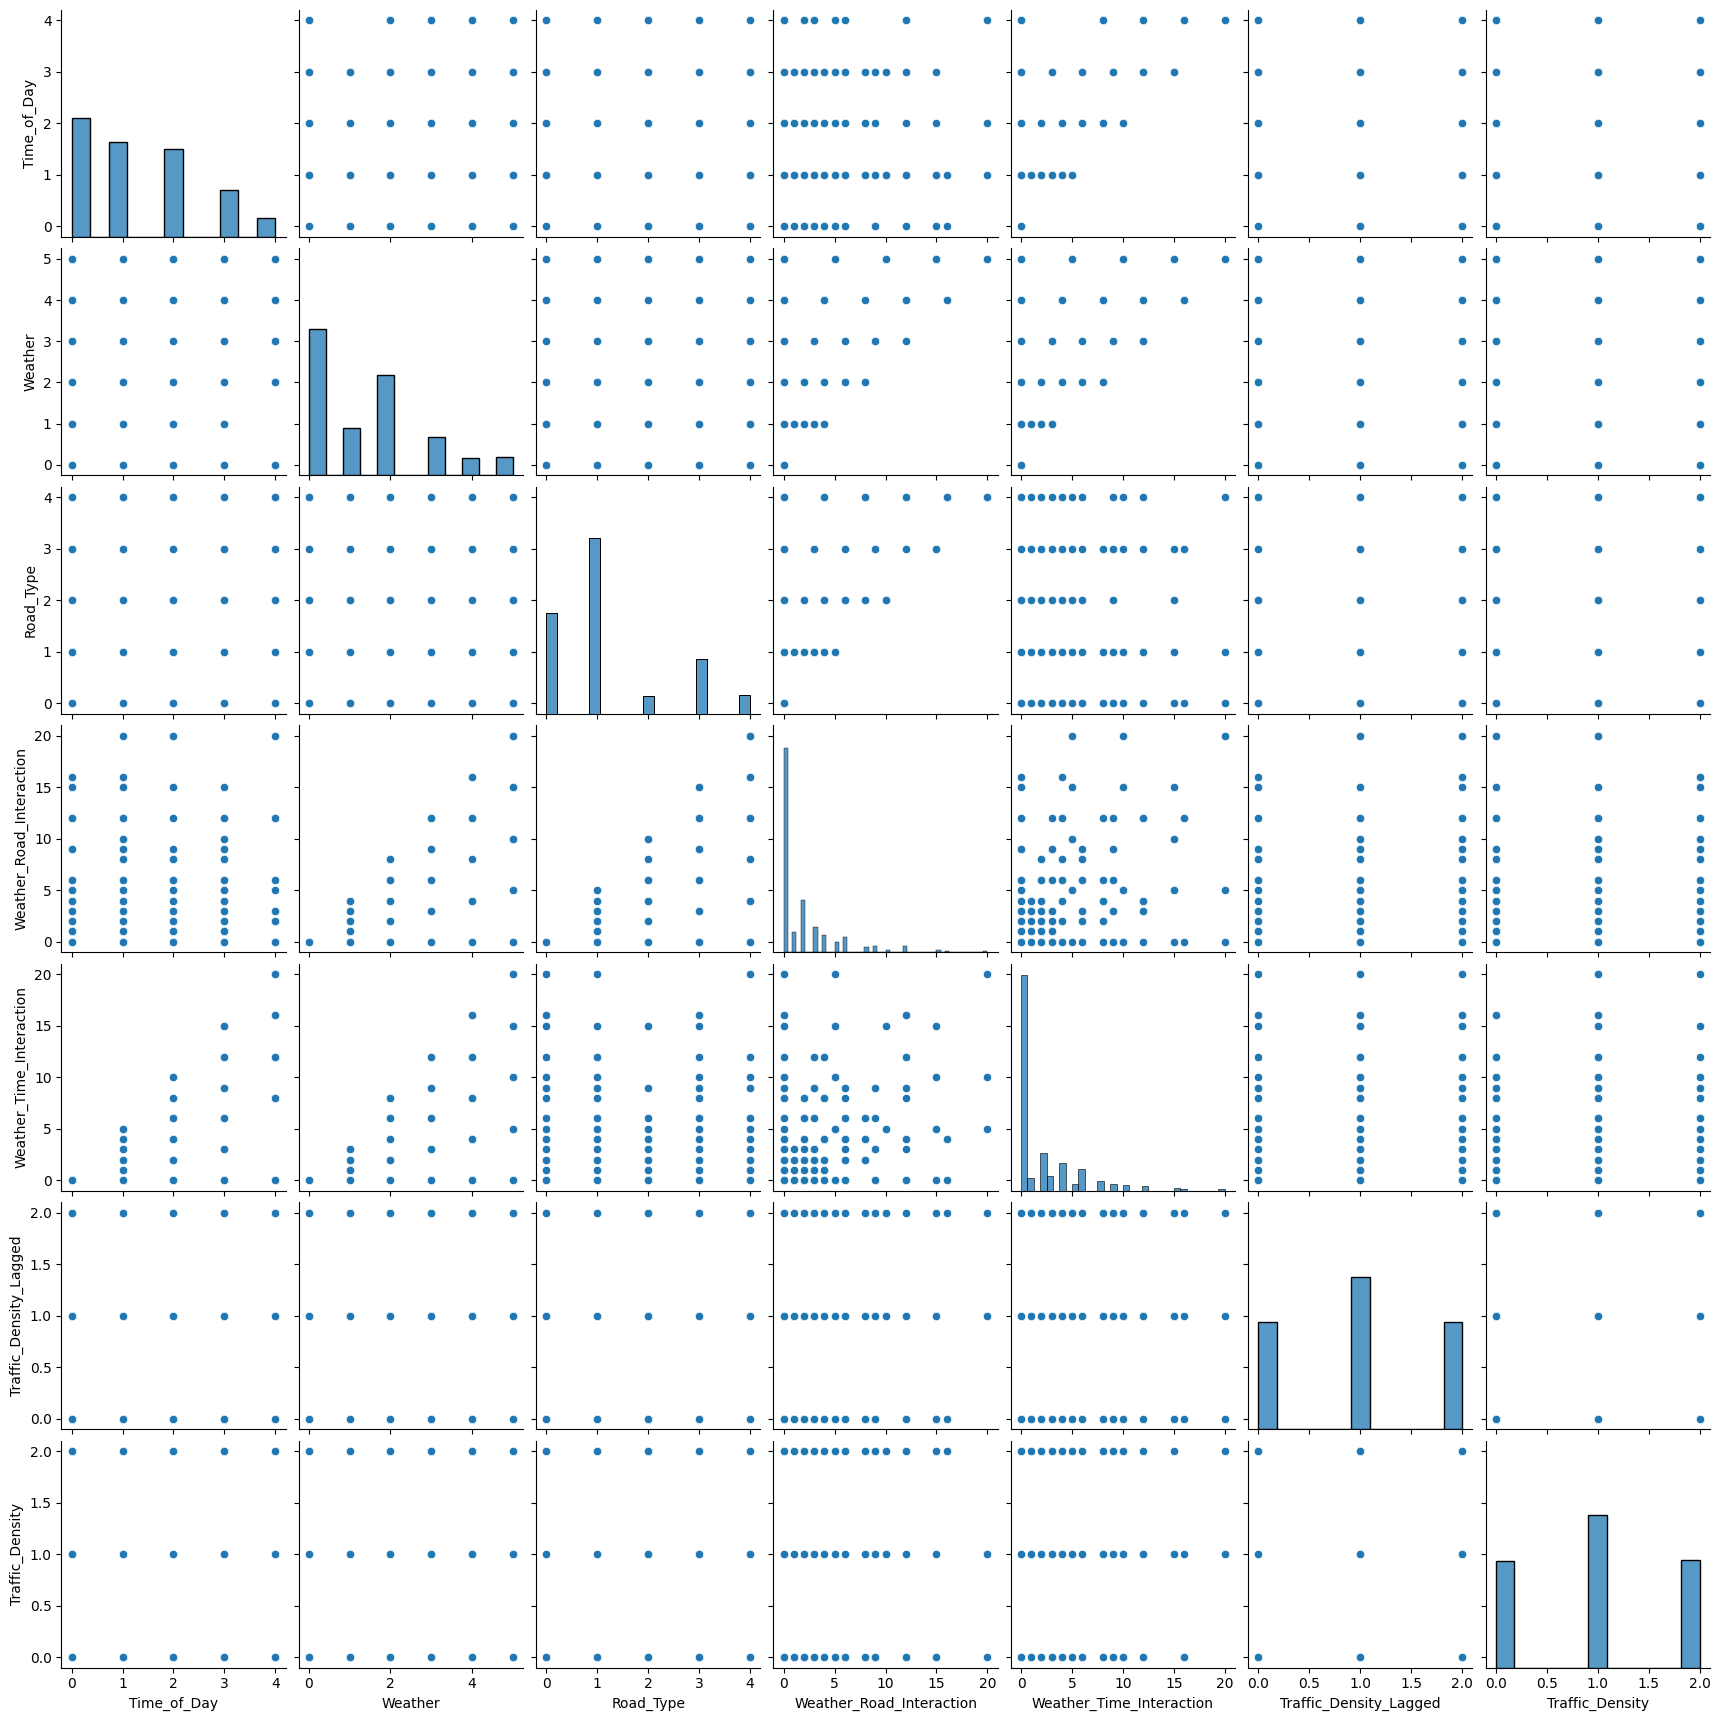

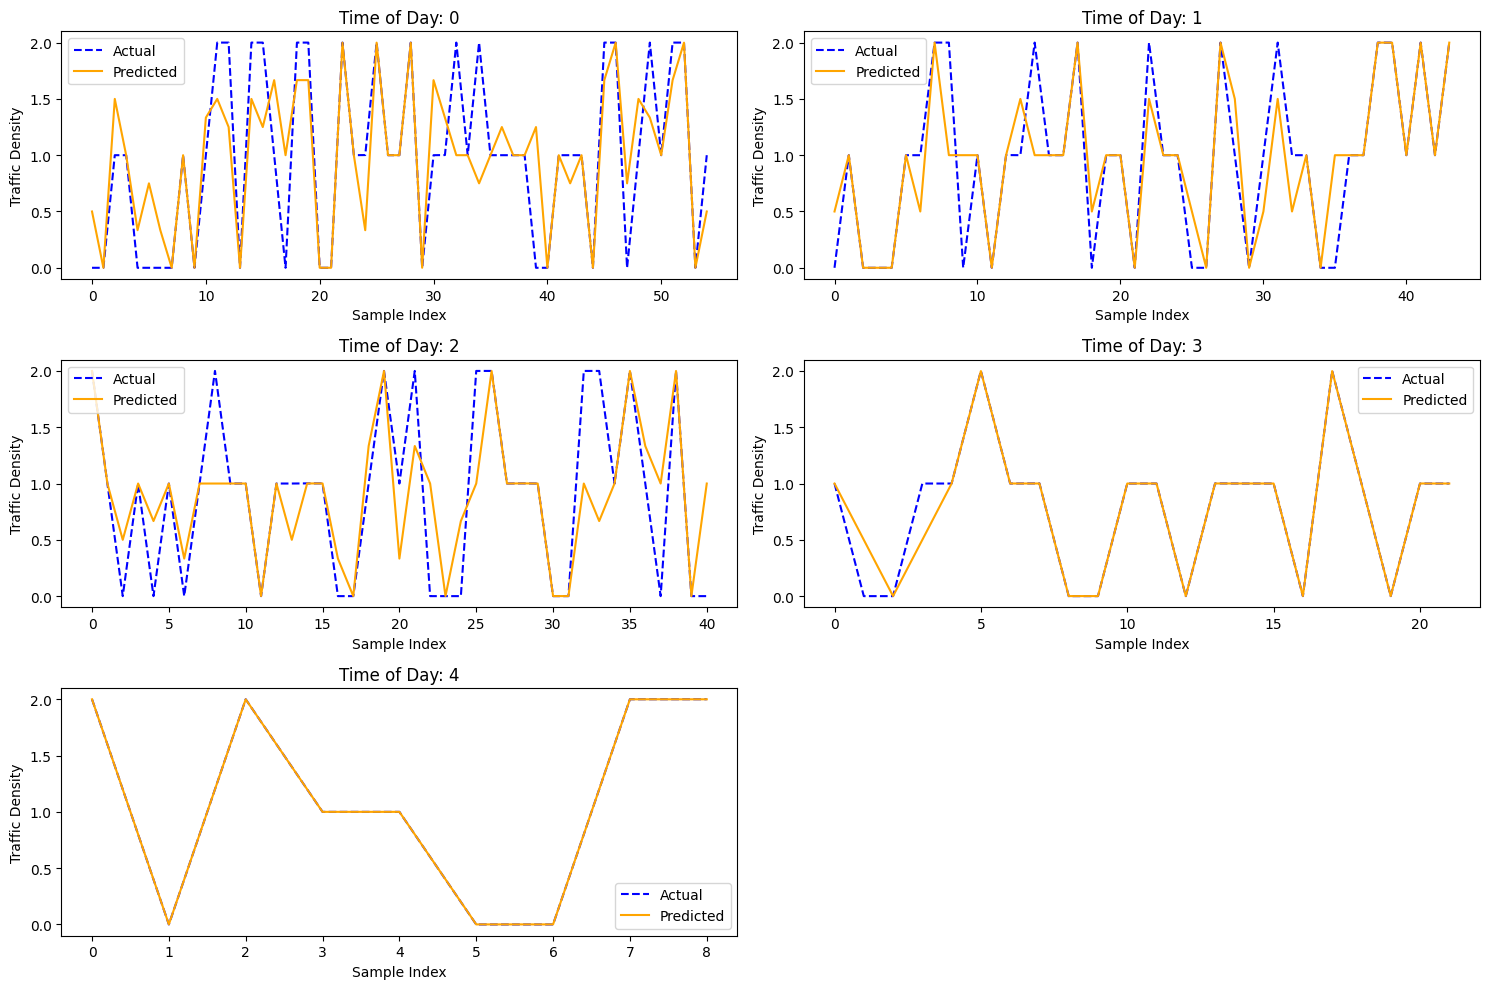

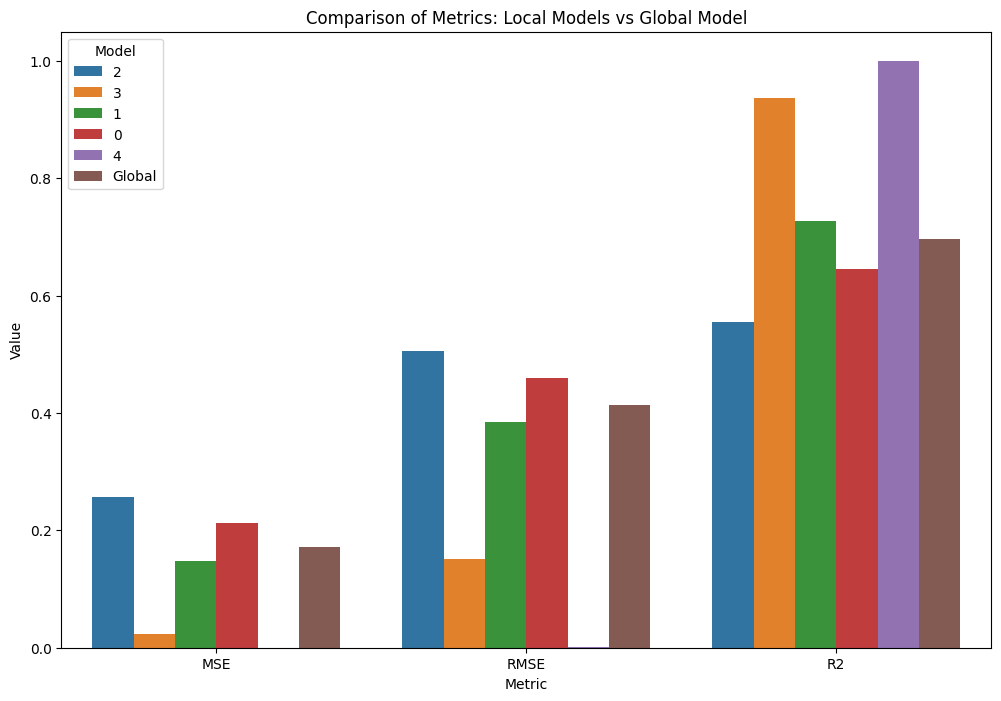

Results saved successfully.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import dgl
import torch
import torch.nn as nn
from dgl.nn import GATConv
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

# Record the start time
start_time = time.time()

# Load dataset
file_path = 'your own path'
df = pd.read_csv(file_path)

# Preprocessing
label_encoders = {}
for column in ['Time_of_Day', 'Weather', 'Road_Type', 'Accident_Severity']:
    if column in df.columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Feature engineering
if 'Weather' in df.columns and 'Road_Type' in df.columns:
    df['Weather_Road_Interaction'] = df['Weather'] * df['Road_Type']
if 'Weather' in df.columns and 'Time_of_Day' in df.columns:
    df['Weather_Time_Interaction'] = df['Weather'] * df['Time_of_Day']
if 'Traffic_Density' in df.columns:
    df['Traffic_Density_Lagged'] = df['Traffic_Density'].shift(1).fillna(df['Traffic_Density'].mean())

# Select top features
feature_columns = [
    'Time_of_Day', 'Weather', 'Road_Type', 'Weather_Road_Interaction',
    'Weather_Time_Interaction', 'Traffic_Density_Lagged'
]
feature_columns = [col for col in feature_columns if col in df.columns]
X = df[feature_columns]
Y = df['Traffic_Density'] if 'Traffic_Density' in df.columns else None
X_selected = SelectKBest(score_func=f_regression, k=min(5, len(feature_columns))).fit_transform(X, Y)

# GNN Integration
num_nodes = df.shape[0]
edges = [(i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j]
graph = dgl.graph(edges)

graph.ndata['features'] = torch.tensor(X_selected, dtype=torch.float32)

class GAT(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_heads):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_feats, hidden_feats, num_heads)
        self.gat2 = GATConv(hidden_feats * num_heads, out_feats, 1)

    def forward(self, g, inputs):
        h = self.gat1(g, inputs)
        h = torch.relu(h.view(h.shape[0], -1))
        h = self.gat2(g, h)
        return h.squeeze()

in_feats = X_selected.shape[1]
hidden_feats = 16
out_feats = 1
num_heads = 4

gat_model = GAT(in_feats, hidden_feats, out_feats, num_heads)
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

inputs = graph.ndata['features']
targets = torch.tensor(Y.values, dtype=torch.float32)

gat_model.train()
for epoch in range(50):
    outputs = gat_model(graph, inputs)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Extract GNN features
gnn_features = gat_model(graph, inputs).detach().numpy()

# Ensure the features are 2D
if len(gnn_features.shape) == 1:
    gnn_features = gnn_features.reshape(-1, 1)

# Local Model Integration
local_predictions = {}
local_metrics = []
all_local_results = []

for node_value in df['Time_of_Day'].unique():
    node_df = df[df['Time_of_Day'] == node_value]
    node_indices = node_df.index
    node_features = gnn_features[node_indices]

    xgb_model_1 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    xgb_model_2 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    xgb_model_3 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    xgb_model_4 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)

    X_train, X_test, Y_train, Y_test = train_test_split(node_features, node_df['Traffic_Density'], test_size=0.2)

    xgb_model_1.fit(X_train, Y_train)
    pred_1 = xgb_model_1.predict(X_test)
    xgb_model_2.fit(np.hstack((X_test, pred_1.reshape(-1, 1))), Y_test)
    pred_2 = xgb_model_2.predict(np.hstack((X_test, pred_1.reshape(-1, 1))))
    xgb_model_3.fit(np.hstack((X_test, pred_2.reshape(-1, 1))), Y_test)
    pred_3 = xgb_model_3.predict(np.hstack((X_test, pred_2.reshape(-1, 1))))
    xgb_model_4.fit(np.hstack((X_test, pred_3.reshape(-1, 1))), Y_test)
    pred_4 = xgb_model_4.predict(np.hstack((X_test, pred_3.reshape(-1, 1))))

    mse = mean_squared_error(Y_test, pred_4)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, pred_4)

    local_predictions[node_value] = (pred_4, Y_test)
    local_metrics.append({'Time_of_Day': node_value, 'MSE': mse, 'RMSE': rmse, 'R2': r2})

    for actual, predicted in zip(Y_test.values, pred_4):
        all_local_results.append({'Time_of_Day': node_value, 'Actual': actual, 'Predicted': predicted})

local_metrics_df = pd.DataFrame(local_metrics)

# Define all_actuals and global_predictions
all_actuals = np.concatenate([actual.values for _, actual in local_predictions.values()])
all_predictions = np.concatenate([pred for pred, _ in local_predictions.values()])

# Train global model on concatenated predictions
global_model = RandomForestRegressor(n_estimators=100)
global_model.fit(all_predictions.reshape(-1, 1), all_actuals)
global_predictions = global_model.predict(all_predictions.reshape(-1, 1))

# Calculate global metrics
global_mse = mean_squared_error(all_actuals, global_predictions)
global_rmse = np.sqrt(global_mse)
global_r2 = r2_score(all_actuals, global_predictions)

# SHAP Interpretability
explainer = shap.Explainer(global_model, X)
shap_values = explainer(X)

# Save SHAP plots
output_dir = 'your own path'
os.makedirs(output_dir, exist_ok=True)

# Bar plot for feature importance
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=X.columns)
plt.savefig(os.path.join(output_dir, 'shap_summary_bar.png'))
plt.show()

# Beeswarm plot for feature impact
shap.summary_plot(shap_values, X, feature_names=X.columns)
plt.savefig(os.path.join(output_dir, 'shap_summary.png'))
plt.show()

# Save results to Excel
excel_path = os.path.join(output_dir, 'model_predictions_and_metrics.xlsx')

with pd.ExcelWriter(excel_path) as writer:
    pd.DataFrame(all_local_results).to_excel(writer, sheet_name='Local Model Predictions', index=False)
    local_metrics_df.to_excel(writer, sheet_name='Local Model Metrics', index=False)
    pd.DataFrame({
        'Actual': all_actuals,
        'Predicted_Global': global_predictions
    }).to_excel(writer, sheet_name='Global Model Predictions', index=False)
    pd.DataFrame({
        'Metric': ['MSE', 'RMSE', 'R2'],
        'Global Model': [mean_squared_error(all_actuals, global_predictions), np.sqrt(mean_squared_error(all_actuals, global_predictions)), r2_score(all_actuals, global_predictions)]
    }).to_excel(writer, sheet_name='Global Model Metrics', index=False)

print("Results saved successfully.")

print("Results saved successfully.")
